<a href="https://colab.research.google.com/github/joomj2000/OpenCV/blob/main/100_Sport_Classification_by_Many_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

# 다운로드 데이터 청크 크기 설정
CHUNK_SIZE = 40960

# 데이터 소스 매핑: 데이터셋의 URL과 경로를 매핑한 문자열
DATA_SOURCE_MAPPING = 'sports-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1209061%2F5595172%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240731%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240731T051805Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1e857687c35470986aded65b49e0cddf64d42e553d550e48e8665bfc8fc154ebe6e1a27bd897c0be52b4d111397b09c5cef75bbca52c4d7f2c069826ab5e5c0a81bc260c5527b5db54bb3d056638b1fed55c770ed1f23495b4853383e5668e7d00b20a4709ed5efcab95b868e2dd097fc6d40a351a9f83469ad2e65551fd801d36276022aa1253cb33e5e0e36bad32ff867a8fcc25aa0b9bd12020552ac563c6447acf851ad5cf872ac2116cb2ca0536e3f4e007b3c9daf22e8d9210ec531299eae1760f132c7feab164add58b42260b5c132346873e145f4b599090845ac73f7f687b672a0ee080f068f341227b7542bf9a1f7e0110f2eca1058211a801b889'

# Kaggle의 입력 및 작업 디렉토리 설정
KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'
KAGGLE_SYMLINK = 'kaggle'

# 기존의 /kaggle/input 디렉토리 마운트 해제 및 삭제
!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
# 새 입력 및 작업 디렉토리 생성
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# 심볼릭 링크 생성
try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

# DATA_SOURCE_MAPPING 문자열을 콤마로 분리하여 각각의 데이터 소스 처리
for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)  # URL 디코딩
    filename = urlparse(download_url).path  # URL에서 파일명 추출
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)  # 데이터 저장 경로 설정

    try:
        # URL에서 데이터 다운로드
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))  # 다운로드 진행 상태 표시
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            # 다운로드한 파일 압축 해제
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 444540604 bytes downloaded
Downloaded and uncompressed: sports-classification
Data source import complete.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf



In [ ]:
train_dir = "/kaggle/input/sports-classification/train"
test_dir =  "/kaggle/input/sports-classification/test"
valid_dir = "/kaggle/input/sports-classification/valid"


In [ ]:
# train_data=tf.keras.utils.image_dataset_from_directory(train_dir,label_mode='categorical',shuffle=False)
# test_data=tf.keras.utils.image_dataset_from_directory(test_dir,shuffle=False,label_mode='categorical')
# validation_data=tf.keras.utils.image_dataset_from_directory(valid_dir,label_mode='categorical',shuffle=False)

In [ ]:
# 배치 사이즈와 이미지 크기 설정
batch_size = 32
img_width, img_height = 224, 224

# 훈련 데이터에 대한 데이터 증강 설정
# 다양한 변형(기울기, 확대/축소, 이동, 수평 뒤집기)을 통해 데이터 증강 수행
train_datagen = ImageDataGenerator(
        shear_range=0.2,  # 기울기 변형 범위
        zoom_range=0.2,   # 확대/축소 범위
        width_shift_range=0.2,  # 수평 이동 범위
        height_shift_range=0.2,  # 수직 이동 범위
        horizontal_flip=True)  # 수평으로 이미지 뒤집기

# 검증 데이터는 증강하지 않음
val_datagen = ImageDataGenerator()

# 훈련 이미지를 배치 단위로 생성
# train_dir: 훈련 데이터가 저장된 디렉토리 경로
train_generator = train_datagen.flow_from_directory(
    train_dir,  # 훈련 데이터 디렉토리
    target_size=(img_width, img_height),  # 이미지 크기 조정
    batch_size=batch_size,  # 배치 사이즈
    class_mode='categorical',  # 다중 클래스 분류
    shuffle=True,  # 데이터를 무작위로 섞기
    seed=42)  # 시드값 설정 (재현성을 위해)

# 검증 이미지를 배치 단위로 생성
# valid_dir: 검증 데이터가 저장된 디렉토리 경로
validation_generator = val_datagen.flow_from_directory(
    valid_dir,  # 검증 데이터 디렉토리
    target_size=(img_width, img_height),  # 이미지 크기 조정
    batch_size=batch_size,  # 배치 사이즈
    class_mode='categorical',  # 다중 클래스 분류
    seed=42)  # 시드값 설정 (재현성을 위해)


Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


# ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

# ImageNet으로 사전 훈련된 ResNet50 모델 불러오기
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# 사전 훈련된 기본 모델의 레이어를 동결 (선택적, 후에 미세 조정 가능)
for layer in base_model.layers:
    layer.trainable = False

# 분류를 위한 커스텀 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)  # 글로벌 평균 풀링 레이어 추가
x = Dense(256, activation='relu')(x)  # 256 유닛의 밀집 레이어 추가
x = Dropout(0.2)(x)  # 드롭아웃 레이어 추가 (과적합 방지)
predictions = Dense(100, activation="softmax")(x)  # 100개의 클래스에 대한 소프트맥스 출력 레이어 추가 (출력 클래스 수는 조정 가능)

# 최종 모델 생성
model = Model(inputs=base_model.input, outputs=predictions)



94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
from keras.callbacks import EarlyStopping

# 조기 종료 콜백 생성
early_stopping = EarlyStopping(
    monitor='val_loss',       # 검증 데이터에서의 손실을 모니터링
    patience=5,                # 검증 손실이 개선되지 않는 에포크 수를 설정 (5 에포크 동안 개선되지 않으면 훈련을 조기 종료)
    restore_best_weights=True  # 조기 종료 후, 훈련 중 가장 좋은 검증 손실에서의 가중치로 모델을 복원
)


In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy'
                 ,metrics=['accuracy'])

In [ ]:
# 모델 훈련
history2 = model.fit(
    train_generator,              # 훈련 데이터 생성기 (배치 단위로 데이터 제공)
    epochs=5,                     # 훈련 에포크 수 (모델을 5번 반복하여 학습)
    validation_data=validation_generator,  # 검증 데이터 생성기 (훈련 중 검증 데이터를 사용하여 성능 평가)
    callbacks=[early_stopping]    # 조기 종료 콜백 (훈련 중 검증 손실이 개선되지 않을 때 훈련을 조기 종료)
)


Epoch 1/5
422/422 [==============================] - 208s 462ms/step - loss: 2.4173 - accuracy: 0.4022 - val_loss: 0.8411 - val_accuracy: 0.7520
Epoch 2/5
422/422 [==============================] - 181s 429ms/step - loss: 1.2544 - accuracy: 0.6413 - val_loss: 0.6227 - val_accuracy: 0.8240
Epoch 3/5
422/422 [==============================] - 175s 415ms/step - loss: 1.0043 - accuracy: 0.7085 - val_loss: 0.5324 - val_accuracy: 0.8260
Epoch 4/5
422/422 [==============================] - 172s 407ms/step - loss: 0.8696 - accuracy: 0.7469 - val_loss: 0.4903 - val_accuracy: 0.8500
Epoch 5/5
422/422 [==============================] - 170s 404ms/step - loss: 0.7852 - accuracy: 0.7637 - val_loss: 0.4608 - val_accuracy: 0.8500


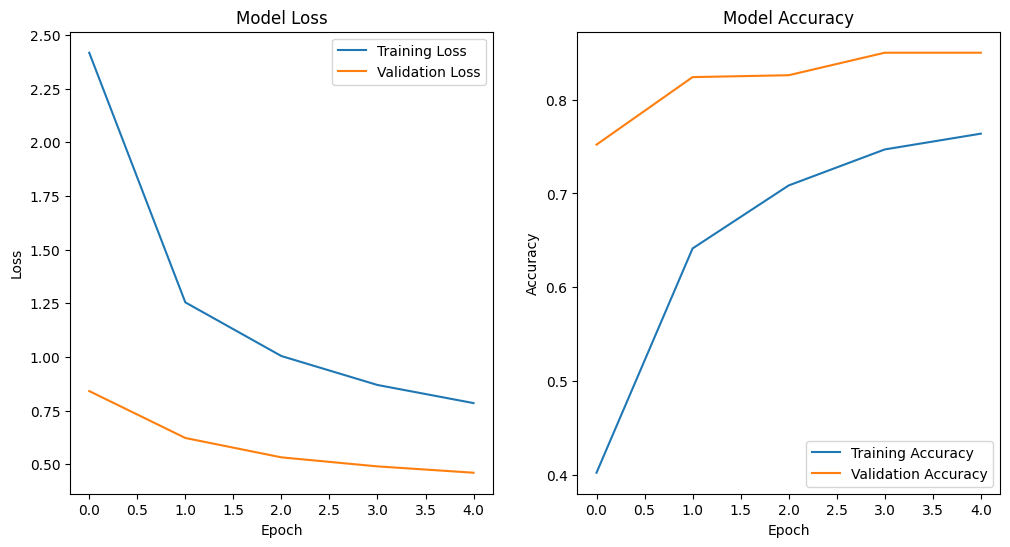

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# 테스트 데이터 생성기 설정
test_datagen = ImageDataGenerator()  # 테스트 데이터에 대한 데이터 증강은 필요없으므로 기본 생성기 사용

# 테스트 데이터 생성기 흐름 설정
test_generator = test_datagen.flow_from_directory(
    test_dir,                       # 테스트 데이터 디렉토리 경로
    target_size=(img_width, img_height),  # 입력 이미지 크기
    batch_size=batch_size,          # 배치 크기
    class_mode='categorical',       # 클래스 레이블 형식
    shuffle=False,                  # 테스트 데이터는 섞지 않음
    seed=42                         # 시드 설정 (결과의 재현성을 위해)
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(
    test_generator,                 # 테스트 데이터 생성기
    verbose=1                       # 평가 진행 상태를 출력
)

# 테스트 결과 출력
print(f"테스트 손실: {test_loss:.4f}")
print(f"테스트 정확도: {test_accuracy:.4f}")


Found 500 images belonging to 100 classes.
16/16 [==============================] - 2s 119ms/step - loss: 0.4403 - accuracy: 0.8660
테스트 손실: 0.4403
테스트 정확도: 0.8660


1/1 [==============================] - 0s 105ms/step


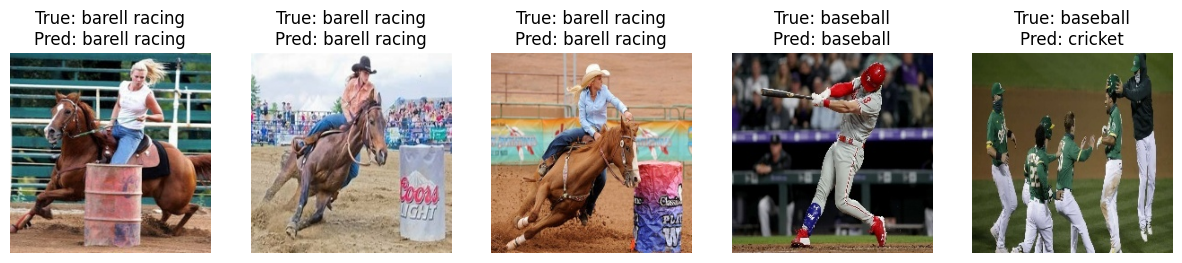

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def visualize_predictions(test_generator, model, num_images=5):
    # 테스트 데이터에서 이미지를 배치 단위로 가져옵니다.
    test_images, test_labels = next(test_generator)

    # 모델 예측 수행
    predictions = model.predict(test_images)

    # 클래스 레이블 추출
    class_labels = list(test_generator.class_indices.keys())

    # 예측 확률을 클래스 레이블로 변환
    predicted_labels = [class_labels[np.argmax(pred)] for pred in predictions]
    true_labels = [class_labels[np.argmax(lbl)] for lbl in test_labels]

    # 시각화할 이미지 수 설정
    num_images = min(num_images, len(test_images))

    # 이미지 시각화
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        img = test_images[i]
        img = img.astype('float32')
        img = (img - np.min(img)) / (np.max(img) - np.min(img))  # 정규화
        plt.imshow(img)
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    plt.show()

# 예시 사용법
visualize_predictions(test_generator, model, num_images=5)
